<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Multiclass_image_classification_with_famous_iconic_women.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uzazam","key":"7abb2778b77e603b3a87069f481fc6a6"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fatiimaezzahra/famous-iconic-women

 99% 834M/838M [00:08<00:00, 70.8MB/s]
100% 838M/838M [00:08<00:00, 104MB/s] 


In [ ]:
from zipfile import ZipFile
file_name = '/content/famous-iconic-women.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

from pathlib import Path
import os.path

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout

from keras.models import Model
import keras.backend as K 
from keras.models import Sequential

In [ ]:
train_dir = Path('/content/output/train')
test_dir = Path('/content/output/valid')

Get filepath and labels

In [ ]:
filepaths_train = list(train_dir.glob(r'**/*.jpg'))
filepaths_test = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
def proc_img(filepath):

  labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))
  filepath = pd.Series(filepath, name = 'Filepath').astype(str)
  labels = pd.Series(labels, name = 'Label')

  #Concatenate filepath and labels
  df = pd.concat([filepath, labels], axis = 1)

  #Shuffle the DataFrame and reset index
  df = df.sample(frac = 1).reset_index(drop = True)

  return df



train_df = proc_img(filepaths_train)
test_df = proc_img(filepaths_test)

#Show the result

train_df.head()


,Filepath,Label
0,/content/output/train/Marie Curie/000058.jpg,Marie Curie
1,/content/output/train/Katharine Graham/000011.jpg,Katharine Graham
2,/content/output/train/Amelia Earhart/000015.jpg,Amelia Earhart
3,/content/output/train/Serena Williams/000047.jpg,Serena Williams
4,/content/output/train/Wangari Maathai/000024.jpg,Wangari Maathai


In [ ]:
train_df.tail()

,Filepath,Label
2647,/content/output/train/Alice Milliat/000048.jpg,Alice Milliat
2648,/content/output/train/Mary Wollstonecraft/0000...,Mary Wollstonecraft
2649,/content/output/train/Celine Dion/000042.jpg,Celine Dion
2650,/content/output/train/Marilyn Monroe/000028.jpg,Marilyn Monroe
2651,/content/output/train/Marilyn Monroe/000011.jpg,Marilyn Monroe


In [ ]:
print(f'Number of training pictures: {train_df.shape[0]}')
print(f'Number of test pictures: {test_df.shape[0]}')

Number of training pictures: 2652
Number of test pictures: 494


Display is picture of the dataset with their labels

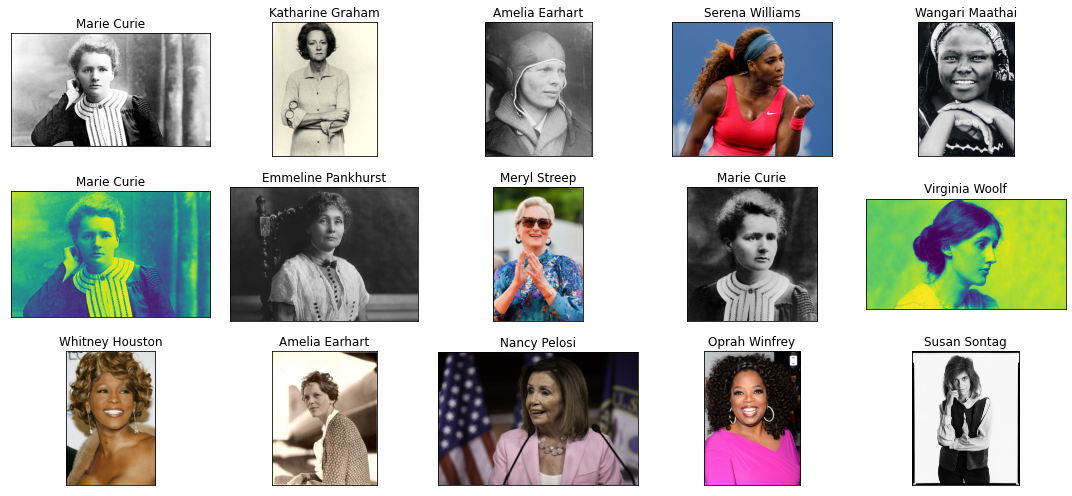

In [ ]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (15, 7), 
                        subplot_kw = {'xticks': [], 'yticks': []})

#fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
#                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(train_df.Filepath[i]))
  ax.set_title(train_df.Label[i])


plt.tight_layout()
plt.show()  

Load the Images with a generator and Data Augmentation

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input, 
    validation_split = 0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input 
    
)




In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 0, 
    subset = 'training',
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15, 
    horizontal_flip = True,
    fill_mode = "nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2122 validated image filenames belonging to 64 classes.
Found 530 validated image filenames belonging to 64 classes.
Found 494 validated image filenames belonging to 64 classes.


Load the pretrained model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3),
                                                     include_top = False,
                                                     weights = 'imagenet',
                                                     pooling = 'avg'
                                                     )

pretrained_model.trainable = False

Train the Model

In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation = 'relu')(pretrained_model.output)

x = tf.keras.layers.Dense(128, activation = 'relu')(x)

outputs = tf.keras.layers.Dense(64, activation = 'softmax')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_images,
    validation_data = val_images,
    epochs = 10,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(
                     monitor = 'val_loss',
                     patience = 5,
                     restore_best_weights = True
                 )
    ]
)

Epoch 1/10
67/67 [==============================] - 108s 2s/step - loss: 3.8549 - accuracy: 0.0990 - val_loss: 3.2623 - val_accuracy: 0.2528
Epoch 2/10
67/67 [==============================] - 106s 2s/step - loss: 2.3895 - accuracy: 0.4307 - val_loss: 2.3244 - val_accuracy: 0.4170
Epoch 3/10
67/67 [==============================] - 105s 2s/step - loss: 1.5309 - accuracy: 0.6239 - val_loss: 1.9122 - val_accuracy: 0.4830
Epoch 4/10
67/67 [==============================] - 104s 2s/step - loss: 1.0322 - accuracy: 0.7502 - val_loss: 1.7567 - val_accuracy: 0.5358
Epoch 5/10
67/67 [==============================] - 103s 2s/step - loss: 0.7211 - accuracy: 0.8209 - val_loss: 1.6894 - val_accuracy: 0.5623
Epoch 6/10
67/67 [==============================] - 103s 2s/step - loss: 0.4788 - accuracy: 0.9020 - val_loss: 1.5962 - val_accuracy: 0.6000
Epoch 7/10
67/67 [==============================] - 103s 2s/step - loss: 0.3155 - accuracy: 0.9472 - val_loss: 1.5791 - val_accuracy: 0.6057
Epoch 8/10
67